In [1]:
import pandas as pd
import numpy as np

from os import listdir
from os.path import isfile, join


import duckdb #pip install duckdb==0.9.1
import plotly.express as px #pip install plotly_express==0.4.0

from datetime import datetime

# 1. \movielens_latest_datasets
https://files.grouplens.org/datasets/movielens/ml-latest-README.html

In [2]:
listdir('файлы для тестов/movielens_latest_datasets')

['genome-scores.csv',
 'genome-tags.csv',
 'links.csv',
 'movies.csv',
 'ratings.csv',
 'README.txt',
 'tags.csv']

In [3]:
df_ratings = pd.read_csv(f'файлы для тестов/movielens_latest_datasets/ratings.csv')
df_ratings.name = 'ratings'

df_movies = pd.read_csv(f'файлы для тестов/movielens_latest_datasets/movies.csv')
df_movies.name = 'movies'

df_tags = pd.read_csv(f'файлы для тестов/movielens_latest_datasets/tags.csv')
df_tags.name = 'tags'

df_links = pd.read_csv(f'файлы для тестов/movielens_latest_datasets/links.csv')
df_links.name = 'links'

df_genome_tags = pd.read_csv(f'файлы для тестов/movielens_latest_datasets/genome-tags.csv')
df_genome_tags.name = 'genome_tags'

df_genome_scores = pd.read_csv(f'файлы для тестов/movielens_latest_datasets/genome-scores.csv')
df_genome_scores.name = 'genome_scores'

# 3.1. Валидность данных (количество пропусков, количество уникальных значений)

In [4]:
df_list = [df_ratings,df_movies,df_tags,df_links,df_genome_tags,df_genome_scores]
list_val = [] 

for df_i in df_list:
    for df_col in df_i.columns:
        all_el = len(df_i)
        uniq_el = df_i[df_col].nunique()
        null_el = len(df_i[df_i[df_col].isnull()])
        list_val.append([df_i.name,df_col,all_el,uniq_el,null_el])
        
df_valid = pd.DataFrame(list_val, columns=['name_df','name_col','cnt_all', 'cnt_iniq', 'cnt_null'])
df_valid['cnt_iniq_perc'] = round((df_valid.cnt_iniq / df_valid.cnt_all)*100,1)
df_valid

,name_df,name_col,cnt_all,cnt_iniq,cnt_null,cnt_iniq_perc
0,ratings,userId,33832162,330975,0,1.0
1,ratings,movieId,33832162,83239,0,0.2
2,ratings,rating,33832162,10,0,0.0
3,ratings,timestamp,33832162,27419646,0,81.0
4,movies,movieId,86537,86537,0,100.0
5,movies,title,86537,86330,0,99.8
6,movies,genres,86537,1796,0,2.1
7,tags,userId,2328315,25280,0,1.1
8,tags,movieId,2328315,53452,0,2.3
9,tags,tag,2328315,153949,17,6.6


# 3.3. Определение самых популярных фильмов (по оценке, ко количеству просмотров)

In [53]:
t_ratings = df_ratings.copy()
t_movies = df_movies.copy()

q = '''
SELECT tm.title, tr.movieId, count(tr.userId) as cnt_view, mean(tr.rating) as mean_rating
FROM t_ratings as tr
LEFT JOIN t_movies as tm
ON tr.movieId = tm.movieId
GROUP BY 1,2
HAVING count(tr.userId) > 100
ORDER BY 4 desc
limit 100
'''
t_fin = duckdb.query(q).to_df()

fig = px.scatter(t_fin,
                 x="cnt_view",
                 y="mean_rating",
                 size="cnt_view",
                 #color="continent",
                 hover_name="title",
                 log_x=True,size_max=30)

fig.update_traces(marker=dict(color='navy'))
fig.update_layout(
    title={'text': 'Популярные фильмы средний рейтинг/кол-во просмотров','x': 0.5}
)

fig.show()

In [55]:
t_fin.head(20)

,title,movieId,cnt_view,mean_rating
0,Planet Earth II (2016),171011,2041,4.451739
1,Planet Earth (2006),159817,3015,4.448093
2,Band of Brothers (2001),170705,2835,4.423986
3,"Shawshank Redemption, The (1994)",318,122296,4.416792
4,Cosmos,171495,625,4.343200
5,Parasite (2019),202439,12399,4.329946
6,"Godfather, The (1972)",858,75004,4.326603
7,Blue Planet II (2017),179135,1267,4.312944
8,Twelve Angry Men (1954),220528,332,4.305723
9,Twin Peaks (1989),198185,1132,4.302562


Были отобраны фильмы у которых от 100 и более оценок пользователей.
В таблице представлены 20 наиболее высоких по рейтингу

# 3.5. Количество выпущенных фильмов (по годам). Посмотреть, какие жанры наиболее популярны в последние годы (что чаще снимают: мелодрамы или боевики)

In [6]:
t1 = t_movies.copy()

# извлекаем год
t1['year_movie'] = t1['title'].str.extract(r'\((\d{4})\)')
t1['year_movie'] = pd.to_numeric(t1['year_movie'], errors='coerce')
t1 = t1.dropna(subset=['year_movie'])
t1['year_movie'] = t1['year_movie'].astype(int)

# Используем функцию explode() для разделения значений в столбце 'genres' на отдельные строки
t1['genres'] = t1['genres'].str.split('|')
t1 = t1.explode('genres')


# t1['gn_action'] = np.where(t1.genres.str.contains('Action', regex=False), 1, 0)

In [7]:
q = '''
SELECT
    year_movie,
    genres,
    COUNT(title) as cnt
FROM t1
GROUP BY 1,2
ORDER BY 1,2
'''
t_fin = duckdb.query(q).to_df()

fig = px.line(t_fin,
              x="year_movie",
              y="cnt",
              color="genres",
              hover_name="genres",
              line_shape="linear",
              #render_mode="svg"
             )
fig.update_layout(
    title={'text': 'Количество выпущенных фильмов','x': 0.5}
)
fig.show()

Наглядно видно, что в фаворитах жанры - драма и комедия. Бурный всплеск этих жанров начался где-то после 60-70х гг.

In [58]:
# t1 - фильмы
# t_ratings - оценки

q = '''
with cte0 as(
SELECT
    tr.userId,
    tr.rating,
    tm.title,
    tm.year_movie,
    tm.genres
FROM t_ratings as tr
LEFT JOIN t1 as tm
ON tr.movieId = tm.movieId
WHERE tm.title IS NOT NULL
)
SELECT
    year_movie,
    genres,
    count(userId) as cnt_view,
    mean(rating) as mean_rating
FROM cte0
GROUP BY 1,2
ORDER BY 1,2
'''
t_fin = duckdb.query(q).to_df()

#t_fin = t_fin[(t_fin.year_movie > 1960)&(t_fin.mean_rating > 3.0)]

fig = px.scatter(t_fin,
                 x=t_fin['year_movie'],
                 y=t_fin['mean_rating'],
                 size="cnt_view",
                 color="genres",
                 hover_name="genres",size_max=60)

fig.update_layout(
    title={'text': 'Кол-во выпущенных фильмов по годам, кол-ву и средней оценке','x': 0.5},
    xaxis=dict(range=[1970, 2023]),
    yaxis=dict(range=[3.0, 4.2])
)
fig.show()

Здесь можно увидеть интересную картину, что фильмов стали выпускать больше, но в целом тренд средней оценки падает.
К старым фильмам относятся более благосклонно, чем к новым.

# 3.7. Можно посмотреть, какие фильмы чаще оценивают в какие месяцы (например пользователь под Новый год может захотеть посмотреть один жанр, под майские праздники другой. Попробовать уловить сезонность

In [75]:
t_ratings['dt'] = pd.to_datetime(t_ratings['timestamp'], unit='s').dt.year
t_ratings['dt_mnth'] = pd.to_datetime(t_ratings['timestamp'], unit='s').dt.month
t_ratings.head()

,userId,movieId,rating,timestamp,dt,dt_mnth,sum_per_dt,sum_dt_all
0,1,1,4.0,1225734739,2008,11,1202202,33832162
1,1,110,4.0,1225865086,2008,11,1202202,33832162
2,1,158,4.0,1225733503,2008,11,1202202,33832162
3,1,260,4.5,1225735204,2008,11,1202202,33832162
4,1,356,5.0,1225735119,2008,11,1202202,33832162


In [99]:
q = '''
with cte0 as(
    SELECT tr.*, t1.title, t1.genres, t1.year_movie
    from t_ratings as tr
    left join t1
    on tr.movieId = t1.movieId
), cte1 as(
    select dt, dt_mnth, genres, count(userId) as cnt_view
    from cte0
    group by 1,2,3
    order by 1,2,3
), cte2 as(
    select *,
        sum(cnt_view) over(partition by dt,genres) as mnth_sum
    from cte1
)
select
    dt,
    dt_mnth,
    genres,
    cnt_view,
    round(cnt_view::decimal/mnth_sum::decimal,3)*100 as perc_view_mnth
from cte2
order by dt desc,dt_mnth

'''
t_fin = duckdb.query(q).to_df()
t_fin.head()

,dt,dt_mnth,genres,cnt_view,perc_view_mnth
0,2023,1,Film-Noir,805,18.7
1,2023,1,Documentary,1929,19.7
2,2023,1,Adventure,26662,18.5
3,2023,1,War,4717,19.2
4,2023,1,Action,33901,18.9


In [111]:
popular_genres = t_fin.query('dt in [2022,2019,2015]')[['genres','cnt_view']].groupby(['genres'])\
.agg('sum')\
.reset_index().sort_values(by='cnt_view', ascending=False).head(10)

popular_genres

,genres,cnt_view
8,Drama,1849077
1,Action,1428900
5,Comedy,1309391
17,Thriller,1196132
2,Adventure,1118200
16,Sci-Fi,902895
6,Crime,752843
15,Romance,603602
9,Fantasy,552139
14,Mystery,380932


In [140]:

fig1 = px.line(t_fin[(t_fin['dt'].isin([2022,2019,2017]))&(t_fin['genres'] == 'Drama')],
               title = 'Drama', x='dt_mnth', y='perc_view_mnth', color='dt')

fig2 = px.line(t_fin[(t_fin['dt'].isin([2022,2019,2017]))&(t_fin['genres'] == 'Action')],
               title = 'Action', x='dt_mnth', y='perc_view_mnth', color='dt')

fig3 = px.line(t_fin[(t_fin['dt'].isin([2022,2019,2017]))&(t_fin['genres'] == 'Thriller')],
               title = 'Thriller', x='dt_mnth', y='perc_view_mnth', color='dt')

fig4 = px.line(t_fin[(t_fin['dt'].isin([2022,2019,2017]))&(t_fin['genres'] == 'Adventure')],
               title = 'Adventure', x='dt_mnth', y='perc_view_mnth', color='dt')

fig5 = px.line(t_fin[(t_fin['dt'].isin([2022,2019,2017]))&(t_fin['genres'] == 'Sci-Fi')],
               title = 'Sci-Fi', x='dt_mnth', y='perc_view_mnth', color='dt')

fig6 = px.line(t_fin[(t_fin['dt'].isin([2022,2019,2017]))&(t_fin['genres'] == 'Crime')],
               title = 'Crime', x='dt_mnth', y='perc_view_mnth', color='dt')


fig1.update_layout(yaxis=dict(range=[0.0, 15.0]))
fig2.update_layout(yaxis=dict(range=[0.0, 15.0]))
fig3.update_layout(yaxis=dict(range=[0.0, 15.0]))
fig4.update_layout(yaxis=dict(range=[0.0, 15.0]))
fig5.update_layout(yaxis=dict(range=[0.0, 15.0]))
fig6.update_layout(yaxis=dict(range=[0.0, 15.0]))

fig1.show()
fig2.show()
fig3.show()
fig4.show()
fig5.show()
fig6.show()

Каких-то особых отклонений по просмотрам жанров в определенном месяце не нашли

# 3.9. Посмотреть количество уникальных пользователей по годам

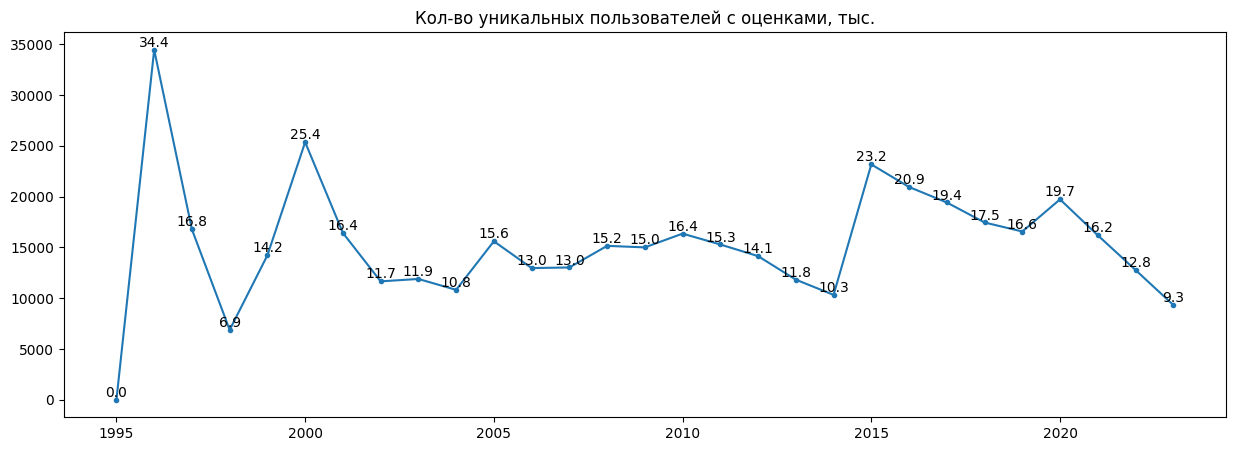

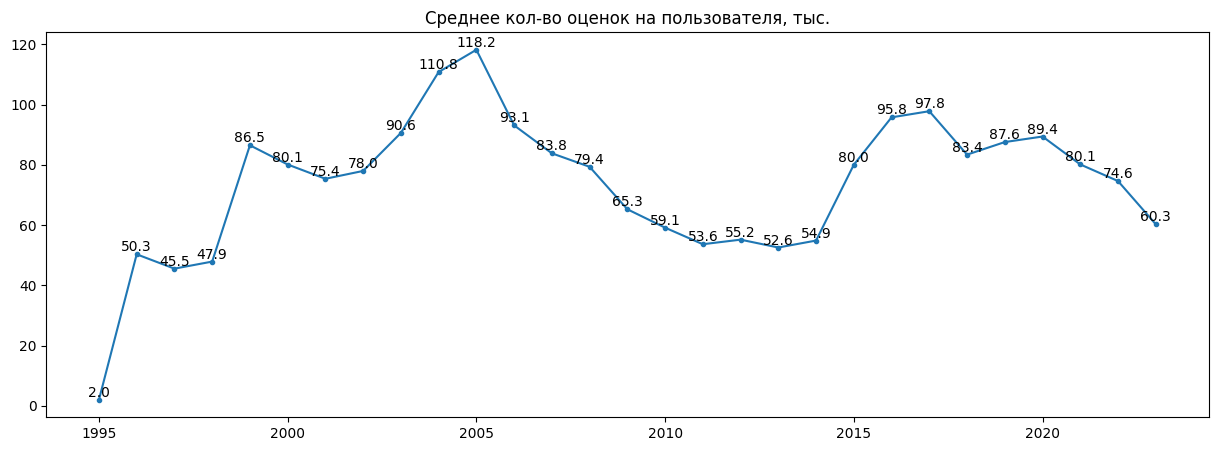

In [191]:
q = '''
with cte0 as(
    select dt, userId, count(rating) as cnt_rate
    from t_ratings
    group by 1,2
)
select dt,
    count(userId) as cnt_uniq_user,
    avg(cnt_rate) as mean_rate_per_user
from cte0
group by 1
order by 1
'''
t_fin = duckdb.query(q).to_df()

x = list(t_fin.dt)
y = list(t_fin.cnt_uniq_user)
plt.figure(figsize=(15, 5))
plt.plot(x, y, marker='.')

for i, j in zip(x, y):
    plt.text(i, j, str(round(j/1000,1)), ha='center', va='bottom')
    
plt.title("Кол-во уникальных пользователей с оценками, тыс.")
plt.show()



x = list(t_fin.dt)
y = list(t_fin.mean_rate_per_user)
plt.figure(figsize=(15, 5))
plt.plot(x, y, marker='.')

for i, j in zip(x, y):
    plt.text(i, j, str(round(j,1)), ha='center', va='bottom')
    
plt.title("Среднее кол-во оценок на пользователя, тыс.")
plt.show()

В 1996 видим огромное количество уникальных пользователей, поставивших оценку.    
При этом на нижнем графике среднее количество оценок на пользователя маленькое.    
Т.е. в 1996 году много людей ставило немного оценок, скорее всего это обусловлено тем, что в данных в 1996 год зашили оценки годов ранее, т.к. в то время интернета не было.    

# 3.11. Попробовать по тегам определить, что влияет на рейтинг фильма

### ПОЛЬЗОВАТЕЛЬСКИЕ ТЕГИ

In [16]:
t_ratings_for_tags = df_ratings.copy()
t_ratings_for_tags['cnt_rate'] = t_ratings_for_tags.groupby('movieId')['userId'].transform('count')
t_ratings_for_tags = t_ratings_for_tags[t_ratings_for_tags.cnt_rate >= 50]

t_ratings_for_tags.head()

,userId,movieId,rating,timestamp,cnt_rate
0,1,1,4.0,1225734739,76813
1,1,110,4.0,1225865086,75514
2,1,158,4.0,1225733503,16591
3,1,260,4.5,1225735204,97202
4,1,356,5.0,1225735119,113581


In [62]:
t_ratings_for_tags = t_ratings_for_tags[['movieId','cnt_rate', 'rating']].groupby(['movieId','cnt_rate'])\
.agg('mean')\
.reset_index()

t_ratings_for_tags.head()

,movieId,cnt_rate,rating
0,1,76813,3.893508
1,2,30209,3.278179
2,3,15820,3.171271
3,4,3028,2.868395
4,5,15801,3.076957


In [19]:
t_tags = df_tags.merge(t_ratings_for_tags, on=['movieId'], how='left')
t_tags.head()

,userId,movieId,tag,timestamp,cnt_rate,rating
0,10,260,good vs evil,1430666558,97202.0,4.09240
1,10,260,Harrison Ford,1430666505,97202.0,4.09240
2,10,260,sci-fi,1430666538,97202.0,4.09240
3,14,1221,Al Pacino,1311600756,47271.0,4.26951
4,14,1221,mafia,1311600746,47271.0,4.26951


In [20]:
q = '''
select tag, avg(rating) as rate_tag
from t_tags
group by 1
order by 2 desc
'''
t_fin = duckdb.query(q).to_df()

# Установка опции для вывода всех строк
pd.set_option('display.max_rows', 100)

t_fin.head(20)

,tag,rate_tag
0,Komodo dragon,4.451739
1,Jaipur,4.451739
2,Namib,4.451739
3,langur,4.451739
4,macaque,4.451739
5,antonishing,4.451218
6,impossible shots,4.449308
7,REALISTIC,4.423986
8,AMERICANS,4.423986
9,ARMY UNIT,4.423986


In [21]:
q = '''
select tag, avg(rating) as rate_tag
from t_tags
group by 1
order by 2
'''
t_fin = duckdb.query(q).to_df()

# Установка опции для вывода всех строк
pd.set_option('display.max_rows', 100)

t_fin.head(20)

,tag,rate_tag
0,warning: some people tryed to kill themselves ...,1.011247
1,would kill not to watch,1.011247
2,Hilarious audio commentary,1.011247
3,movie hell,1.011247
4,death on screen,1.011247
5,Guarini is a goon,1.011247
6,worst acting,1.011247
7,Insipid dialogue,1.214450
8,can't ever rate it - cuz I can't ever watch th...,1.214450
9,Unromantic,1.214450


В данных таблицах высчитана средняя оценка фильма (фильмы > 50 оценками) с подобным тегом.

Просмотрев 20 "худших"/"лучших" тегов нельзя однозначно что-то сказать, с одной стороны теги достаточно субъективные и не характеризуют фильм с положительной или негативной стороны.
С другой стороны, возможно провести лемантизацию тегов и разбиение на части, для выделения облака слов.

### ГЕНОМНЫЕ ТЕГИ

In [22]:
tags_genome = df_genome_scores.merge(df_genome_tags, on=['tagId'], how='left')
tags_genome = tags_genome[tags_genome.relevance > 0.5][['movieId','tag']]

tags_genome = tags_genome.merge(t_ratings_for_tags, on=['movieId'], how='left')
tags_genome.head()

,movieId,tag,cnt_rate,rating
0,1,3d,76813.0,3.893508
1,1,action,76813.0,3.893508
2,1,adventure,76813.0,3.893508
3,1,affectionate,76813.0,3.893508
4,1,animal movie,76813.0,3.893508


In [23]:
q = '''
select tag, avg(rating) as rate_tag
from tags_genome
group by 1
order by 2 desc
'''
t_fin = duckdb.query(q).to_df()

# Установка опции для вывода всех строк
pd.set_option('display.max_rows', 100)

t_fin.head(20)

,tag,rate_tag
0,brilliant,4.167204
1,perfect,4.142499
2,awesome,4.009345
3,afi 100,3.997308
4,afi 100 (laughs),3.905890
5,miyazaki,3.889671
6,afi 100 (movie quotes),3.881327
7,studio ghibli,3.873108
8,intelligent,3.871892
9,moving,3.868978


In [24]:
q = '''
select tag, avg(rating) as rate_tag
from tags_genome
group by 1
order by 2
'''
t_fin = duckdb.query(q).to_df()

# Установка опции для вывода всех строк
pd.set_option('display.max_rows', 100)

t_fin.head(20)

,tag,rate_tag
0,overrated,1.909736
1,awful,2.037742
2,bad,2.188662
3,boring,2.205764
4,lame,2.234783
5,unintentionally funny,2.319826
6,bad script,2.340709
7,so bad it's good,2.353771
8,horrible,2.374204
9,bad sequel,2.392245


Геномные теги лучше характеризуют фильм)

# 3.16. Вывести статистики в процентном соотношении - сколько оценок в год

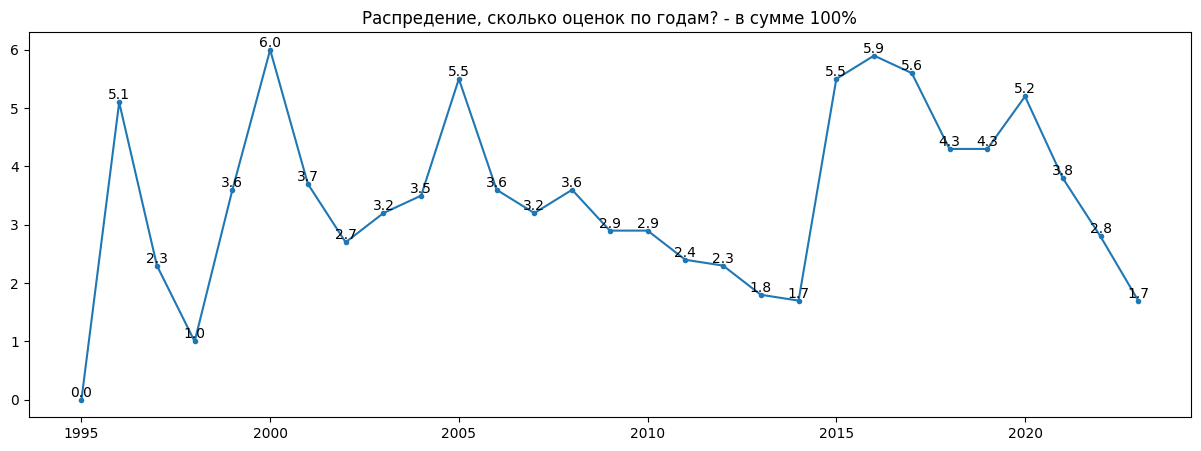

In [184]:
t_ratings['sum_per_dt'] = t_ratings.groupby('dt')['userId'].transform('count')
t_ratings['sum_dt_all'] = len(t_ratings)

q = '''
select dt, round(sum_per_dt::decimal/sum_dt_all::decimal,3)*100 as perc_rate
from(SELECT distinct dt, sum_per_dt, sum_dt_all FROM t_ratings) as t0
ORDER BY 1
'''
t_fin = duckdb.query(q).to_df()


x = list(t_fin.dt)
y = list(t_fin.perc_rate)
plt.figure(figsize=(15, 5))
plt.plot(x, y, marker='.')

for i, j in zip(x, y):
    plt.text(i, j, str(round(j,1)), ha='center', va='bottom')
    
plt.title("Распредение, сколько оценок по годам? - в сумме 100%")
plt.show()

# 3.17. Вывести статистики в процентном соотношении - сколько оценок в год в год выпуска фильма

In [26]:
t1_uniq = t1[['movieId','title','year_movie']].drop_duplicates()
t1_uniq.head()

,movieId,title,year_movie
0,1,Toy Story (1995),1995
1,2,Jumanji (1995),1995
2,3,Grumpier Old Men (1995),1995
3,4,Waiting to Exhale (1995),1995
4,5,Father of the Bride Part II (1995),1995


In [27]:
ratings_movies_year = t_ratings.merge(t1_uniq, on='movieId', how='left')
ratings_movies_year = ratings_movies_year[ratings_movies_year.dt==ratings_movies_year.year_movie]

ratings_movies_year['sum_per_dt'] = ratings_movies_year.groupby('dt')['userId'].transform('count')
ratings_movies_year['sum_dt_all'] = len(ratings_movies_year)

ratings_movies_year.head()

,userId,movieId,rating,timestamp,dt,dt_mnth,sum_per_dt,sum_dt_all,title,year_movie
80,2,95,2.0,835816548,1996,6,141223,1160327,Broken Arrow (1996),1996.0
83,2,141,5.0,835816548,1996,6,141223,1160327,"Birdcage, The (1996)",1996.0
152,2,786,4.0,835817123,1996,6,141223,1160327,Eraser (1996),1996.0
181,3,185029,5.0,1536174197,2018,9,42348,1160327,A Quiet Place (2018),2018.0
182,3,187593,3.0,1536174244,2018,9,42348,1160327,Deadpool 2 (2018),2018.0


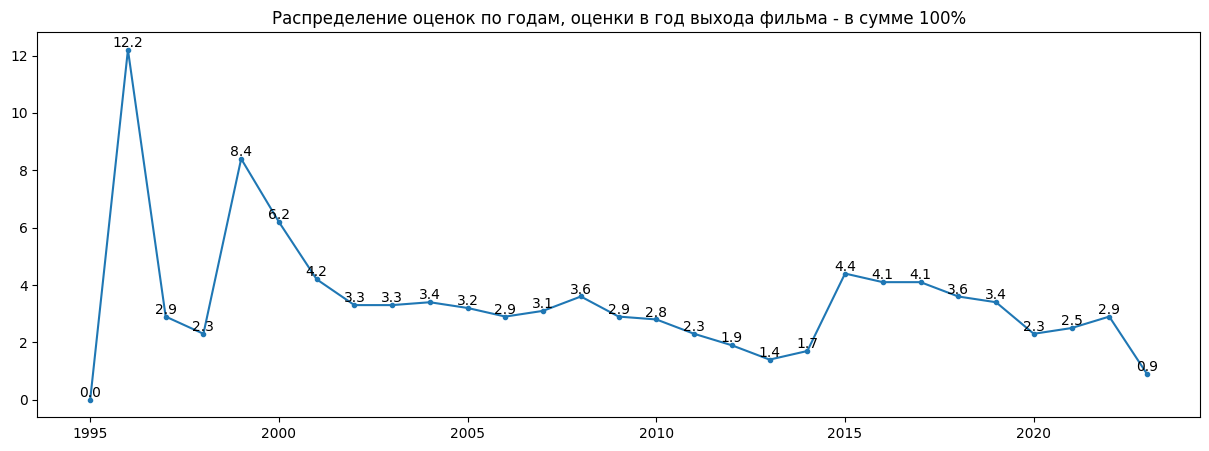

In [183]:
q = '''
with cte0 as(
    select *
    from ratings_movies_year
    where dt::int = year_movie::int
)
select dt, round(sum_per_dt::decimal/sum_dt_all::decimal,3)*100 as perc_rate
from(SELECT distinct dt, sum_per_dt, sum_dt_all FROM cte0) as t0
ORDER BY 1
'''
t_fin = duckdb.query(q).to_df()


x = list(t_fin.dt)
y = list(t_fin.perc_rate)
plt.figure(figsize=(15, 5))
plt.plot(x, y, marker='.')

for i, j in zip(x, y):
    plt.text(i, j, str(round(j,1)), ha='center', va='bottom')
    
plt.title("Распределение оценок по годам, оценки в год выхода фильма - в сумме 100%")
plt.show()

# 2. Анализ датасета по IMDB - TBD

# рейтинг фильма и сколько оценок на imdb
title_ratings

# количество сезонов и эпизодов фильма, сериала
title_episode (нам не совсем подходит)

# список по людям, фио, профессия, года жизни, с какими фильмами связан
name_basics

# режиссер фильма
title_crew

# название фильма на разных языках
title_akas (не совсем нам подходит)

# фильм, дата выпуска
title_basics

# что в фильме делал человек
title_principals

title_basics['IMDBID'] = title_basics['tconst'].str.replace('tt', '').astype('Int64')
чтобы к movieid привести их id

# список по людям, фио, профессия, года жизни, с какими фильмами связан
imdb_name_basics = pd.read_csv('файлы для тестов\\imdb\\imdb_datasets\\name_basics\\data.tsv', sep='\t')
imdb_name_basics.head()

# режиссер фильма
imdb_title_crew = pd.read_csv('файлы для тестов\\imdb\\imdb_datasets\\title_crew\\data.tsv', sep='\t')
imdb_title_crew.head()

# фильм, дата выпуска
imdb_title_basics = pd.read_csv('файлы для тестов\\imdb\\imdb_datasets\\title_basics\\data.tsv', sep='\t')
imdb_title_basics.head()

# что в фильме делал человек
imdb_title_principals = pd.read_csv('файлы для тестов\\imdb\\imdb_datasets\\title_principals\\data.tsv', sep='\t')
imdb_title_principals.head()